In [1]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import circmean, circstd

### Load old

In [123]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/"
folder_name = "20230805-3_MBON21hDeltaB_syntGCAMP7f_odor_apple_patchy_nobar"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
#odor_threshold = 5
bar_jump = False

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
behav_df = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=10, prominence=0.1, min_time_gap=60)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

AttributeError: module 'imaging_behavior_functions' has no attribute 'combine_df'

In [25]:
behav_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,0.000000,0.000000,0.000000,4.668550,0.000000,0.000000,0.000000,0,4.668550,0,0.000000,0.000000
1,0.240513,0.920712,-12.209755,-4.587285,4.571852,12.209755,4.587285,17.717753,1,4.571852,0,-0.167960,0.042338
2,0.481026,0.257430,-1.682556,-3.523187,4.138059,1.682556,3.523187,5.463173,1,4.138059,0,-0.207300,0.064987
3,0.721539,1.405668,-8.278464,-5.172633,4.069592,8.278464,5.172633,14.856765,1,4.069592,0,-0.426891,0.190547
4,0.962052,0.527885,-3.114793,-0.220508,3.963693,3.114793,0.220508,3.863187,1,3.963693,0,-0.513888,0.228608
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,598.877285,3.003833,-0.372376,2.408172,2.095496,0.372376,2.408172,5.784381,1,-23.037246,0,-178.397982,157.320472
2491,599.117798,0.243480,-3.002783,-0.989662,2.104643,3.002783,0.989662,4.235926,1,-23.028098,0,-178.374458,157.283112
2492,599.358311,-0.334739,-0.661456,0.275579,2.128497,0.661456,0.275579,1.271774,1,-23.004244,0,-178.316613,157.351773
2493,599.598824,0.339760,2.815691,0.330911,2.146475,2.815691,0.330911,3.486362,1,-22.986266,0,-178.416519,157.276460


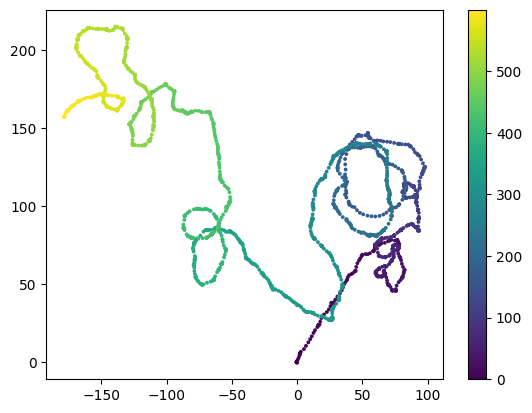

In [26]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

In [27]:
jumpbar_pd = pd.read_csv(example_path_data+'../panel_heading_1.txt',names = ['panel_heading','time','count'])
jumpbar_pd

,panel_heading,time,count
0,0.000000,0.020994,1
1,0.000000,0.027992,2
2,0.000080,0.032990,3
3,6.283024,0.037988,4
4,6.282815,0.043989,5
...,...,...,...
30976,4.841745,617.440808,30977
30977,4.854375,617.460801,30978
30978,4.856249,617.481795,30979
30979,4.854501,617.500788,30980


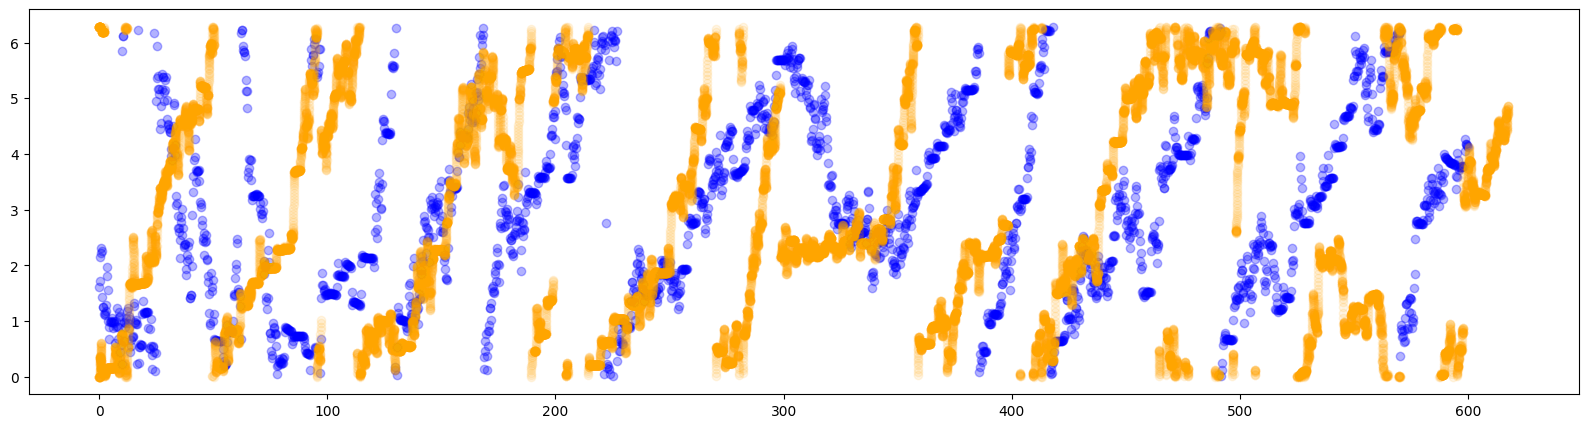

In [31]:
fig_ex, ax = plt.subplots(figsize=[20,5])
x1 = 3000
x2 = 0
ax.scatter(behav_df.time[0:len(behav_df)], 2*np.pi-behav_df.heading[0:len(behav_df)],color ='blue',alpha = 0.3)
ax.scatter(jumpbar_pd.time[:len(jumpbar_pd)-x2], jumpbar_pd.panel_heading[x2:len(jumpbar_pd)],color ='orange',alpha = 0.1)


In [17]:
heading_intp = np.interp(behav_df.time, jumpbar_pd.time[:-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:])
behav_df['heading_jump'] = heading_intp

In [18]:
heading_adj = 2*np.pi-jumpbar_pd.panel_heading[x2:]
jump_label = np.abs(np.diff(np.unwrap(heading_adj)))>2 
jump_idx = np.where(jump_label)

Text(0, 0.5, 'fw velocity (mm/s)')

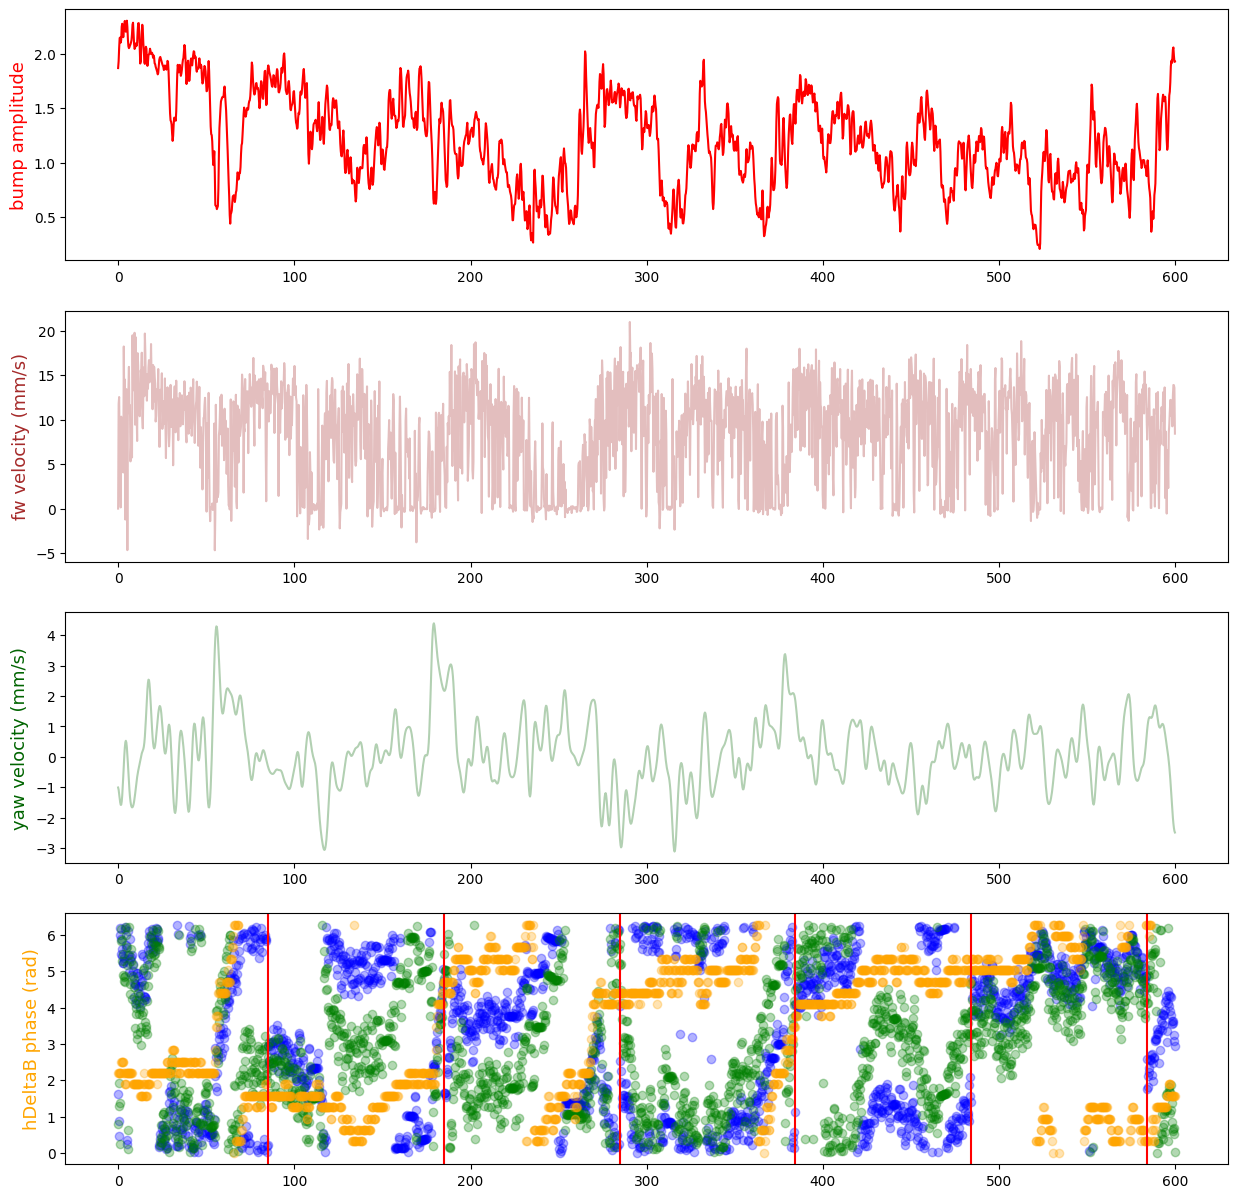

In [20]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(behav_df) 
ax[0].plot(behav_df.time[ind1:ind2], param_df.amplitude[ind1:ind2],color = 'red')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax[3].scatter(behav_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='blue',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], behav_df.heading[ind1:ind2],color ='green',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], 2*np.pi-param_df.phase[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
for i in range(len(jump_idx[0])):
    ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
ax[3].set_ylabel('hDeltaB phase (rad)', fontsize = 13, color = 'orange')
#ax2 = ax[3].twinx()
ax[2].plot(behav_df.time[ind1:ind2], imaging_behavior_functions.apply_gaussian_smoothing(behav_df.yawV[ind1:ind2],5),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(behav_df.time[ind1:ind2],behav_df.fwV[ind1:ind2], color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')

In [13]:
# Function to find the index of the closest value
def find_closest_indices(values, highlight_values):
    indices = []
    for value in highlight_values:
        # Compute absolute difference and find the index of the minimum
        index = np.abs(values - value).argmin()
        indices.append(index)
    return indices

In [14]:
highlight_times = np.array(jumpbar_pd.time[jump_idx[0]])
# Find the index of the closest value for each highlight value
highlight_indices = find_closest_indices(behav_df.time, highlight_times)

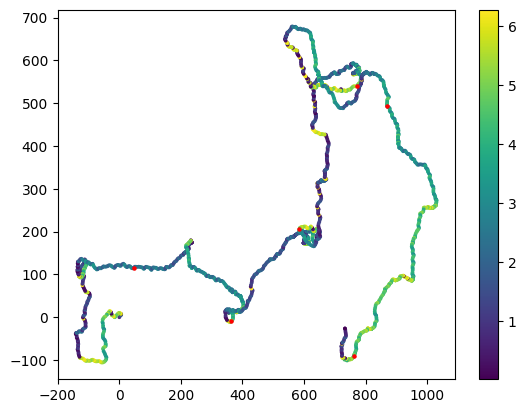

In [15]:
fig = plt.scatter(xPos,yPos,s=3,c = behav_df.heading)
# Highlight specific time points in red
for idx in highlight_indices:
    plt.scatter(xPos[idx], yPos[idx], s=5,color='red')
plt.colorbar(fig)

### Load new

In [25]:
def get_roi_seq_2(roi_df, trial_number):
    roi_df['trialNum'] = roi_df['trialNum'].apply(lambda x: x[0][0])
    
    # Filter the DataFrame to only include rows with the specified trial number
    roi_df = roi_df[roi_df['trialNum'] == trial_number].reset_index(drop=True)
    
    roi_names = roi_df['roiName'].apply(lambda x: x[0])
    roi_hdeltab = roi_names[roi_names.str.contains('hDeltaB', case=False)]
    hdeltab_index = roi_hdeltab.index
    roi_epg = roi_names[roi_names.str.contains('EPG')]
    epg_index = roi_epg.index
    roi_fr1 = roi_names[roi_names.str.contains('FR1') & ~roi_names.str.contains('CRE')]
    fr1_index = roi_fr1.index
    
    hdeltab_seq = roi_hdeltab.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    
    if epg_index.size > 0:
        epg_seq = roi_epg.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        epg_seq = None 
    
    if fr1_index.size > 0:
        fr1_seq = roi_fr1.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fr1_seq = None 
    
    return np.array(roi_names), hdeltab_index, epg_index, fr1_index, hdeltab_seq, epg_seq, fr1_seq

In [30]:
def calculate_pva_hdeltab(activity_matrix, neural_df):
    num_neurons, time_steps = activity_matrix.shape
    directions = np.linspace(0, 2*np.pi, num_neurons, endpoint=False)
    
    # Calculate vector components for each neuron's activity
    x_components = np.cos(directions)[:, np.newaxis] * activity_matrix
    y_components = np.sin(directions)[:, np.newaxis] * activity_matrix
    
    # Sum components across neurons for each time step
    sum_x = np.sum(x_components, axis=0)
    sum_y = np.sum(y_components, axis=0)
    
    # Calculate PVA for each time step
    pva_phase = np.arctan2(sum_y, sum_x)  # Phase in radians
    pva_amplitude = np.sqrt(sum_x**2 + sum_y**2)  # Magnitude of the vector
    
    # Compute baseline: mean activity across neurons for each time step
    baseline = np.mean(activity_matrix, axis=0)
    
    # Save computed values into neural_df
    neural_df['phase'] = pva_phase
    neural_df['amplitude'] = pva_amplitude
    neural_df['baseline'] = baseline
    
    return neural_df


In [91]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
folder_name = "20250302-2_MBON09hDeltaB_barhold"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 3
bar_jump = True
is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = get_roi_seq_2(roi_df, trial_num)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions.extract_heatmap_2(neural_df, roi_kw, roi_kw2)
    #neural_df,paramfit_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
    neural_df = calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=95)
#behav_df = imaging_behavior_functions.detect_jumps_unwrapped(behav_df, 'heading', 'time', jump_threshold=np.pi/4, min_time_between_jumps=60)
behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_5_v2(behav_df,50,time_lengths=[300,120,300],detection_threshold=0.05,required_consecutive=5)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)

#behav_df = imaging_behavior_functions.calc_segment_modes_filtered_v2(behav_df)
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df)

#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)
# Get both filtered data and mask
'''motion_threshold=1
behav_df, motion_mask = filter_by_motion(behav_df, 
                                                motion_threshold, 
                                                return_mask=True)'''
# Apply same mask to neural_df if needed
#neural_df = neural_df[motion_mask]
merged_df = imaging_behavior_functions.merge_dataframes(neural_df, behav_df,method = 'nearest')


Loaded using mat73.


In [92]:
merged_df.columns

Index(['time', 'MBON09L', 'MBON09R', 'hDeltaB_0', 'hDeltaB_1', 'hDeltaB_2',
       'hDeltaB_3', 'hDeltaB_4', 'hDeltaB_5', 'hDeltaB_6', 'hDeltaB_7',
       'hDeltaB_8', 'hDeltaB_9', 'hDeltaB_10', 'hDeltaB_11', 'hDeltaB_12',
       'hDeltaB_13', 'hDeltaB_14', 'hDeltaB_15', 'hDeltaB_16', 'hDeltaB_17',
       'phase', 'amplitude', 'baseline', 'xPos', 'yPos', 'fwV', 'sideV',
       'odor', 'yawV', 'heading', 'heading_diff', 'odor_state',
       'absolute_circular_diff', 'jump_detected', 'abssideV', 'absyawV',
       'net_motion', 'net_motion_state', 'speed', 'theta_g', 'rho_t'],
      dtype='object')

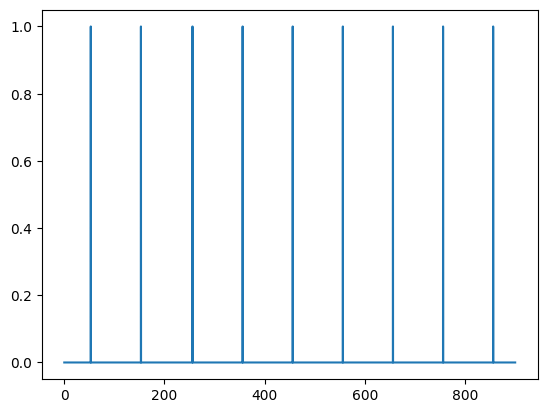

In [93]:
plt.plot(merged_df.time,merged_df.jump_detected)

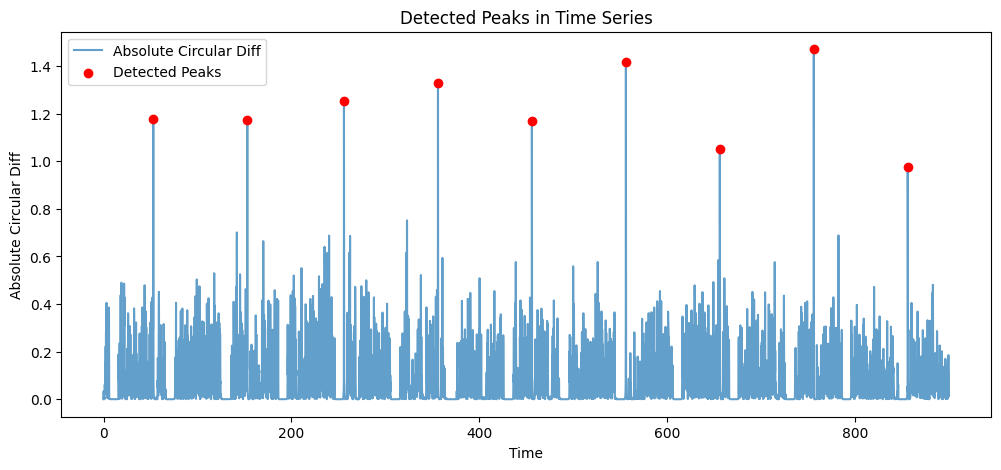

In [94]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(behav_df["time"], behav_df["absolute_circular_diff"], label="Absolute Circular Diff", alpha=0.7)
plt.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='red', label="Detected Peaks", zorder=3)
plt.xlabel("Time")
plt.ylabel("Absolute Circular Diff")
plt.legend()
plt.title("Detected Peaks in Time Series")
plt.show()




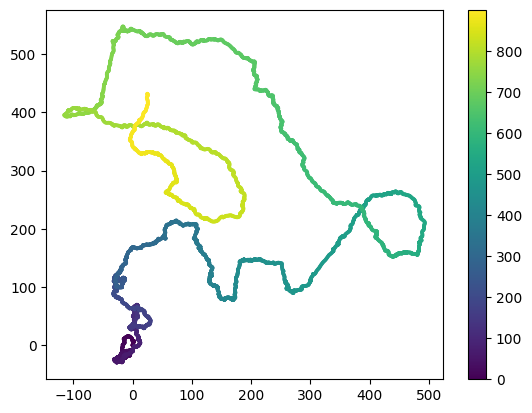

In [95]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

In [96]:
def plot_aligned_traces(
    df, binary_col, query_col, time_col, color_col=None, align_to="on", window=(-1, 1), bins=None, is_circular=False
):
    """
    Plots query variable traces aligned to binary state ON or OFF transitions.
    If `is_circular` is True, uses a scatter plot.
    """
    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Store all extracted traces
    all_traces = []
    time_shifts = []
    colors = []

    # Iterate over transitions
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]  # Get transition time
        start_time, end_time = t0 + window[0], t0 + window[1]  # Define window range
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]  # Extract data

        if not subset.empty:
            aligned_time = subset[time_col] - t0  # Align time to transition (t=0)
            all_traces.append(subset[query_col].values)  # Store query variable values
            time_shifts.append(aligned_time.values)  # Store aligned time values
            colors.append(df.loc[idx, color_col] if color_col else None)  # Store color variable

    # Convert to arrays
    all_traces = np.array(all_traces, dtype=object)
    time_shifts = np.array(time_shifts, dtype=object)

    # Default to blue if no color column is provided
    if color_col is None:
        colors = None
    else:
        colors = np.array(colors)

    # Handle binning of the color variable
    if color_col and bins is not None:
        bin_edges = np.linspace(colors.min(), colors.max(), bins + 1)
        color_bins = np.digitize(colors, bin_edges) - 1  # Bin indices
        unique_bins = np.unique(color_bins)
    else:
        color_bins = colors if colors is not None else None
        unique_bins = np.unique(colors) if colors is not None else None

    # Define colormap
    cmap = cm.get_cmap("viridis", len(unique_bins)) if color_col else cm.get_cmap("viridis")
    norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max()) if color_col else None

    plt.figure(figsize=(8, 5))

    # Choose plot type based on is_circular
    for i, (time_trace, query_trace) in enumerate(zip(time_shifts, all_traces)):
        if color_col:
            bin_idx = color_bins[i] if bins is not None else colors[i]
            color = cmap(norm(bin_idx))
        else:
            color = cmap(i / len(all_traces))

        if is_circular:
            plt.scatter(time_trace, query_trace, s=15, color=color, alpha=0.5)
        else:
            plt.plot(time_trace, query_trace, alpha=0.3, color=color)

    # Labels and legend
    plt.xlabel("Time (s, aligned to transition)")
    plt.ylabel(query_col)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)  # Mark transition point
    plt.title(f"{query_col} aligned to {binary_col} {align_to.upper()} transitions")
    
    if color_col:
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=color_col)
    
    plt.grid(True)
    plt.show()


def plot_aligned_traces_2(
    df, binary_col, query_col, time_col, color_col=None, align_to="on", window=(-1, 1), bins=None, is_circular=False
):
    """
    Plots query variable traces aligned to binary state ON or OFF transitions.
    For each trace, the mean over the prestimulus window (t < 0) is subtracted
    so that the baseline is aligned across events.
    If `is_circular` is True, the baseline is computed using circular statistics
    (assuming values are in the range 0 to 2pi) and the subtraction is performed modulo 2pi.
    """
    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Store all extracted traces
    all_traces = []
    time_shifts = []
    colors = []

    # Iterate over transitions
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]  # Get transition time
        start_time, end_time = t0 + window[0], t0 + window[1]  # Define window range
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]  # Extract data

        if not subset.empty:
            # Align time to transition (t=0)
            aligned_time = subset[time_col].values - t0
            query_trace = subset[query_col].values

            # Identify the prestimulus period (t < 0)
            baseline_mask = aligned_time < 0
            if baseline_mask.any():
                baseline_values = query_trace[baseline_mask]
            else:
                baseline_values = query_trace

            # Compute baseline and subtract it from the trace
            if is_circular:
                # Circular mean: compute mean of exp(i*theta) then extract angle
                baseline = np.angle(np.mean(np.exp(1j * baseline_values)))
                # Ensure baseline is in [0, 2pi]
                if baseline < 0:
                    baseline += 2 * np.pi
                # Subtract baseline modulo 2pi
                query_trace = (query_trace - baseline) % (2 * np.pi)
            else:
                baseline = np.mean(baseline_values)
                query_trace = query_trace - baseline

            # Append adjusted trace and corresponding aligned time
            all_traces.append(query_trace)
            time_shifts.append(aligned_time)
            colors.append(df.loc[idx, color_col] if color_col else None)

    # Convert to arrays
    all_traces = np.array(all_traces, dtype=object)
    time_shifts = np.array(time_shifts, dtype=object)

    # Default to blue if no color column is provided
    if color_col is None:
        colors = None
    else:
        colors = np.array(colors)

    # Handle binning of the color variable
    if color_col and bins is not None:
        bin_edges = np.linspace(colors.min(), colors.max(), bins + 1)
        color_bins = np.digitize(colors, bin_edges) - 1  # Bin indices
        unique_bins = np.unique(color_bins)
    else:
        color_bins = colors if colors is not None else None
        unique_bins = np.unique(colors) if colors is not None else None

    # Define colormap
    cmap = cm.get_cmap("rainbow", len(unique_bins)) if color_col else cm.get_cmap("rainbow")
    norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max()) if color_col else None

    plt.figure(figsize=(8, 5))

    # Plot each trace
    for i, (time_trace, query_trace) in enumerate(zip(time_shifts, all_traces)):
        if color_col:
            bin_idx = color_bins[i] if bins is not None else colors[i]
            color = cmap(norm(bin_idx))
        else:
            color = cmap(i / len(all_traces))

        if is_circular:
            plt.scatter(time_trace, query_trace, s=15, color=color, alpha=0.7)
        else:
            plt.plot(time_trace, query_trace, alpha=0.7, color=color)

    # Labels and legend
    plt.xlabel("Time (s, aligned to transition)")
    plt.ylabel(query_col)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)  # Mark transition point
    plt.title(f"{query_col} aligned to {binary_col} {align_to.upper()} transitions")
    
    if color_col:
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=color_col)
    
    plt.grid(True)
    plt.show()


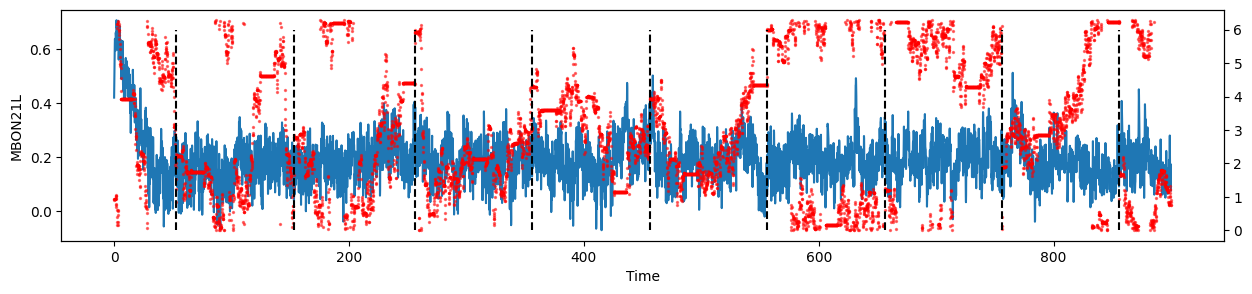

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(neural_df.time[idx1:idx2], neural_df['MBON09R'][idx1:idx2])
ax2 = ax.twinx()
ax2.scatter(behav_df.time[idx1:idx2], behav_df.heading[idx1:idx2], color='red',s = 2, alpha=0.5)
# Extracting indices where jump_detected is 1
jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('MBON21L')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

C:\Users\wilson\AppData\Local\Temp\ipykernel_27332\1508562843.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_bins)) if color_col else cm.get_cmap("rainbow")


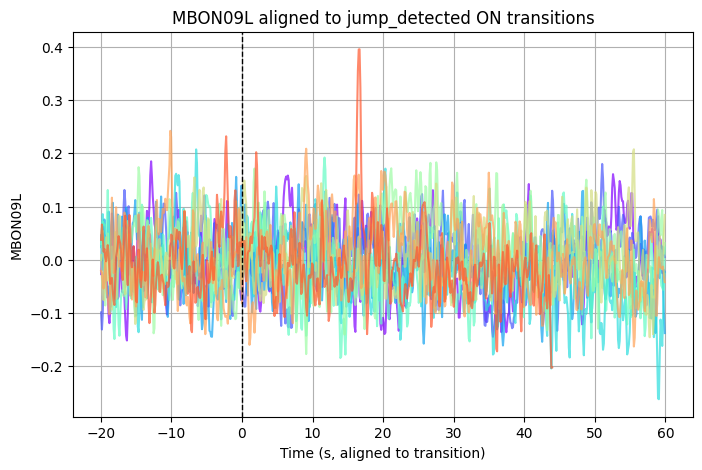

In [100]:
plot_aligned_traces_2(
    merged_df, 'jump_detected', 'MBON09L', 'time', color_col=None, align_to="on", window=(-20, 60), bins=None
)

C:\Users\wilson\AppData\Local\Temp\ipykernel_27332\1508562843.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_bins)) if color_col else cm.get_cmap("rainbow")


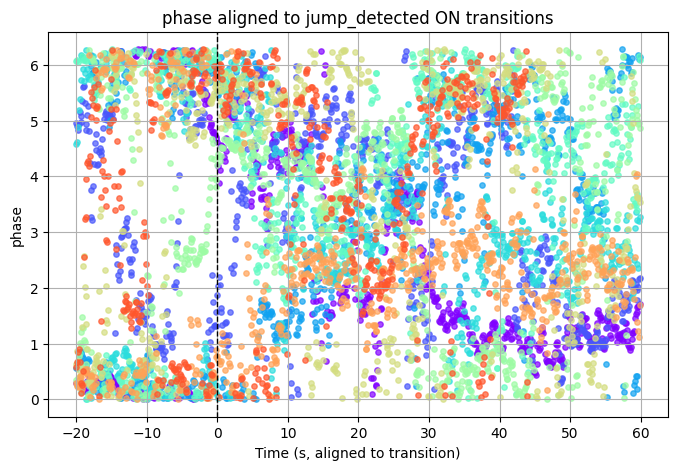

In [101]:
plot_aligned_traces_2(
    merged_df, 'jump_detected', 'phase', 'time', color_col=None, align_to="on", window=(-20, 60), bins=None,is_circular=True
)

C:\Users\wilson\AppData\Local\Temp\ipykernel_27332\1508562843.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_bins)) if color_col else cm.get_cmap("rainbow")


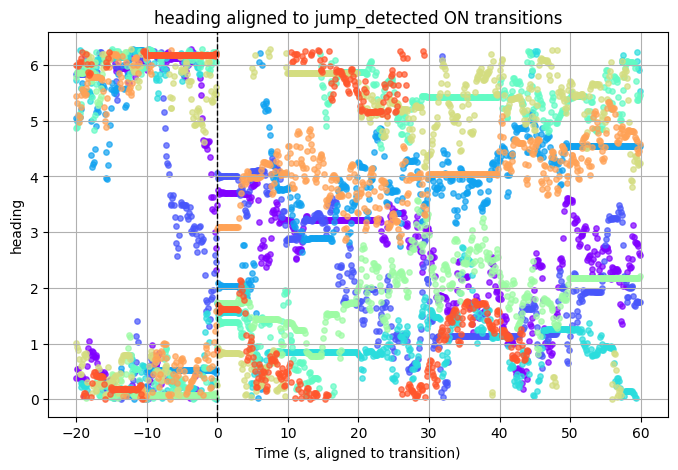

In [102]:
plot_aligned_traces_2(
    merged_df, 'jump_detected', 'heading', 'time', color_col=None, align_to="on", window=(-20, 60), bins=None,is_circular=True
)